# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [3]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'2020/CFS_APCP_Basin_Sums.csv',sep=',')
tmp_data = pd.read_csv(dir+f'2020/CFS_TMP_Basin_Avgs.csv',sep=',')
evap_data = pd.read_csv(dir+f'2020/CFS_EVAP_Basin_Sums.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Defined Functions

In [4]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [5]:
def convert_kg_to_cms(df):

    # Calculate the number of seconds for each month
    df['seconds'] = df.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # Convert millimeters to meters
    df['WaterErie_m3'] = df['WaterErie'] / 1000
    df['WaterOntario_m3'] = df['WaterOntario'] / 1000
    df['WaterSuperior_m3'] = df['WaterSuperior'] / 1000
    df['WaterMichHuron_m3'] = (df['WaterMichigan'] + df['WaterHuron']) / 1000

    # Convert the data to cubic meters per second
    df['WaterErie_cms'] = df['WaterErie_m3'] / df['seconds']
    df['WaterOntario_cms'] = df['WaterOntario_m3'] / df['seconds']
    df['WaterSuperior_cms'] = df['WaterSuperior_m3'] / df['seconds']
    df['WaterMichHuron_cms'] = df['WaterMichHuron_m3'] / df['seconds']
    
    return df

In [6]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [59]:
# Read in GLCC RNBS data
data_4 = pd.read_csv(dir + 'Input/rnbs_glcc.csv', sep=',')

# Ensure 'Date' column is treated as string and modified as necessary
date_strs = data_4['Date'].astype(str)

date_rnbs = []

for date_str in date_strs:
    # Insert leading zero before month (if necessary)
    if len(date_str) == 6:
        date_str = date_str[:4] + '0' + date_str[4:]

    # Insert leading zero before day (if necessary)
    if len(date_str) == 7:
        date_str = date_str[:6] + '0' + date_str[6:]

    # Convert to datetime object
    datetime_obj = datetime.strptime(date_str, '%Y%m%d')

    # Format the datetime object as a string in the desired format
    date_tmp = datetime_obj.strftime('%Y-%m-%d')

    # Append formatted date to list
    date_rnbs.append(date_tmp)

# Replace the original 'Date' column with formatted dates
data_4['Date'] = date_rnbs

# Convert 'Date' column to datetime format
data_4['Date'] = pd.to_datetime(data_4['Date'])

# Add a new column 'Month' extracting month from 'Date'
data_4['Month'] = data_4['Date'].dt.month

# Select only the data that matches with the CFSR dates
start_date = '2020-01-01'
end_date = '2020-12-01'
obs = data_4[(data_4['Date'] >= start_date) & (data_4['Date'] <= end_date)]

su_rnbs = obs['sup']
er_rnbs = obs['eri']
on_rnbs = obs['ont']
mh_rnbs = obs['mic_hur']

In [60]:
print(obs)

           Date         sup     mic_hur         eri         ont  Month
1440 2020-01-01   12.750390  129.966000  239.331100  334.782500      1
1441 2020-02-01  -29.972390   43.529040   38.465750  163.799000      2
1442 2020-03-01   94.156750  170.995800  212.973100  369.801600      3
1443 2020-04-01   89.221120  171.469100   83.665560  229.092600      4
1444 2020-05-01  120.965300  217.756100  145.496500  190.503800      5
1445 2020-06-01  124.972800  132.206400   12.243740   63.712150      6
1446 2020-07-01  140.254300   95.354250  -10.543220   49.026720      7
1447 2020-08-01   73.233030   76.100030  -83.291450    1.400764      8
1448 2020-09-01   77.514800    7.320154 -147.945200  -71.845610      9
1449 2020-10-01    7.846396   24.984650  -55.879070    7.003818     10
1450 2020-11-01   43.977780   39.040820   -5.101559   55.578680     11
1451 2020-12-01  -52.309310   56.845800   68.530940  142.877900     12


## Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [9]:
# Convert Total Precipitation to cms
pcp_data = convert_kg_to_cms(pcp_data)

# Convert Total Evaporation to cms
evap_data = convert_kg_to_cms(evap_data)

In [10]:
print(pcp_data)

           cfsrun  year  month     BasinErie     WaterErie      LandErie  \
0      2020010100  2020      1  5.039449e+12  8.437616e+11  4.924873e+12   
1      2020010100  2020      2  5.103290e+12  8.769925e+11  4.913393e+12   
2      2020010100  2020      3  1.172140e+13  1.851843e+12  1.139989e+13   
3      2020010100  2020      4  5.899706e+12  9.391540e+11  5.870735e+12   
4      2020010100  2020      5  7.103447e+12  1.102071e+12  7.109200e+12   
...           ...   ...    ...           ...           ...           ...   
13955  2020123018  2021      5  4.916998e+12  7.517275e+11  4.754891e+12   
13956  2020123018  2021      6  8.294270e+12  1.201716e+12  8.365534e+12   
13957  2020123018  2021      7  1.112022e+13  1.672541e+12  1.097369e+13   
13958  2020123018  2021      8  1.162130e+13  2.030638e+12  1.065492e+13   
13959  2020123018  2021      9  9.481841e+12  1.513401e+12  9.132614e+12   

       BasinOntario  WaterOntario   LandOntario    BasinHuron  ...  \
0      3.675493e+

In [11]:
# Features
X = pd.DataFrame({
    'su_pcp': pcp_data['WaterSuperior_cms'],
    'er_pcp': pcp_data['WaterErie_cms'],
    'on_pcp': pcp_data['WaterOntario_cms'],
    'mh_pcp': pcp_data['WaterMichHuron_cms'], #data_1['WaterMichigan']+data_1['WaterHuron'], # add the sums
    'su_evap': evap_data['WaterSuperior_cms'],
    'er_evap': evap_data['WaterErie_cms'],
    'on_evap': evap_data['WaterOntario_cms'],
    'mh_evap': evap_data['WaterMichHuron_cms'], #data_2['WaterMichigan']+data_2['WaterHuron'], # add the sums
    'su_tmp': tmp_data['WaterSuperior'],
    'er_tmp': tmp_data['WaterErie'],
    'on_tmp': tmp_data['WaterOntario'],
    'mh_tmp': (tmp_data['WaterMichigan']+tmp_data['WaterHuron'])/2 # take the average temp
})

### Predict Components using GP
Scale the data and run it through the trained GP model. Put the results into a new dataframe.

In [12]:
# Predict RNBS using GP

# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
print(df_y_pred)

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


               sup          eri          ont          mih
0       444.100472   979.613208  1220.144448  1984.547979
1       255.926228  1016.310655   928.069977  2172.844267
2        75.121853  2423.600916  2432.014490  6419.798642
3       724.737419   988.872742  1340.539250  2698.950809
4      3550.881487   285.681446   489.804456  1344.156727
...            ...          ...          ...          ...
13955  3125.360309  -169.501300   240.683874   574.055547
13956  1147.267542   155.372847   526.000315  3792.924539
13957  1859.465547   181.925526    -7.357267  3159.429728
13958   534.422244   507.806037   961.640943  2125.617948
13959  3700.005899   699.540304   893.631665  5192.822954

[13960 rows x 4 columns]


In [13]:
df = pd.DataFrame()
df['cfsrun'] = pcp_data['cfsrun']
df['month'] = pcp_data['month'].astype(int)
df['year'] = pcp_data['year'].astype(int)

In [14]:
df_y = pd.merge(df, df_y_pred, left_index=True, right_index=True, how='inner')

In [15]:
print(df_y)

           cfsrun  month  year          sup          eri          ont  \
0      2020010100      1  2020   444.100472   979.613208  1220.144448   
1      2020010100      2  2020   255.926228  1016.310655   928.069977   
2      2020010100      3  2020    75.121853  2423.600916  2432.014490   
3      2020010100      4  2020   724.737419   988.872742  1340.539250   
4      2020010100      5  2020  3550.881487   285.681446   489.804456   
...           ...    ...   ...          ...          ...          ...   
13955  2020123018      5  2021  3125.360309  -169.501300   240.683874   
13956  2020123018      6  2021  1147.267542   155.372847   526.000315   
13957  2020123018      7  2021  1859.465547   181.925526    -7.357267   
13958  2020123018      8  2021   534.422244   507.806037   961.640943   
13959  2020123018      9  2021  3700.005899   699.540304   893.631665   

               mih  
0      1984.547979  
1      2172.844267  
2      6419.798642  
3      2698.950809  
4      1344.156727

Currently, we are only storing 1 set of model results

In [16]:
df_y.to_csv(dir+f'RNBS_forecasts_2020.csv',sep=',',index=False)

Convert component units from [cms] to [mm]

In [17]:
df_y_mm = convert_cms_to_mm(df_y)

In [90]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].median().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(df_y_mm,'sup')
mean_er, min_er, max_er = mean_min_max(df_y_mm,'eri')
mean_on, min_on, max_on = mean_min_max(df_y_mm,'ont')
mean_mh, min_mh, max_mh = mean_min_max(df_y_mm,'mih')

In [ ]:
df_y_mm_filtered = df_y_mm[(df_y_mm['year'] == 2020)]
print(df_y_mm_filtered)

Begin plotting

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

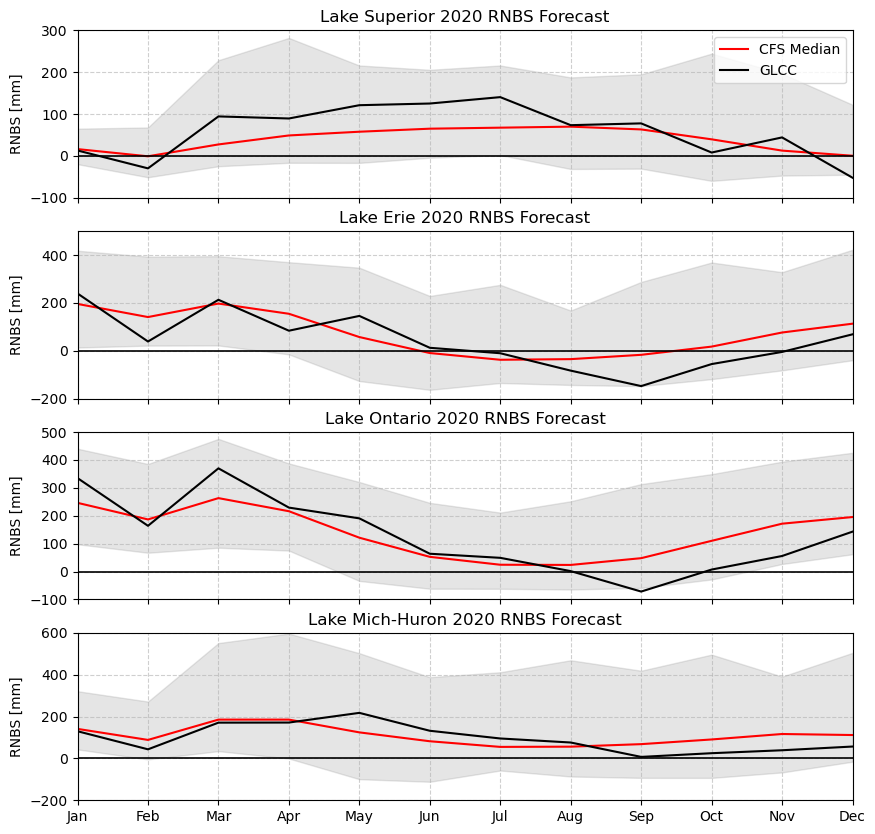

In [114]:
x_values = np.arange(0,12,1)  # x-axis values

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(x_values, mean_su['sup'][0:12], color='red', linestyle='-', linewidth=1.5, label='CFS Median')
axs[0].plot(x_values, su_rnbs, color='black', linestyle='-', linewidth=1.5, label='GLCC')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_su['sup'][0:12], max_su['sup'][0:12], color='gray', alpha=0.2)
axs[0].set_ylabel('RNBS [mm]')
axs[0].set_title('Lake Superior 2020 RNBS Forecast')
axs[0].set_ylim(-100, 300)
axs[0].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[0].set_xticks(np.arange(0,12,1))
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_er['eri'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[1].plot(x_values, er_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_er['eri'][0:12], max_er['eri'][0:12], color='gray', alpha=0.2)
axs[1].set_ylabel('RNBS [mm]')
axs[1].set_title('Lake Erie 2020 RNBS Forecast')
axs[1].set_ylim(-200, 500)
axs[1].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[1].set_xticks(np.arange(0,12,1))
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on['ont'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[2].plot(x_values, on_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on['ont'][0:12], max_on['ont'][0:12], color='gray', alpha=0.2)
axs[2].set_ylabel('RNBS [mm]')
axs[2].set_title('Lake Ontario 2020 RNBS Forecast')
axs[2].set_ylim(-100, 500)
axs[2].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[2].set_xticks(np.arange(0,12,1))
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh['mih'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[3].plot(x_values, mh_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh['mih'][0:12], max_mh['mih'][0:12], color='gray', alpha=0.2)
axs[3].set_ylabel('RNBS [mm]')
axs[3].set_title('Lake Mich-Huron 2020 RNBS Forecast')
axs[3].set_ylim(-200, 600)
axs[3].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[3].set_xticks(np.arange(0,12,1))
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels([calendar.month_abbr[mean_mh['month'][j]] for j in range(12)])

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\130635391.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\130635391.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


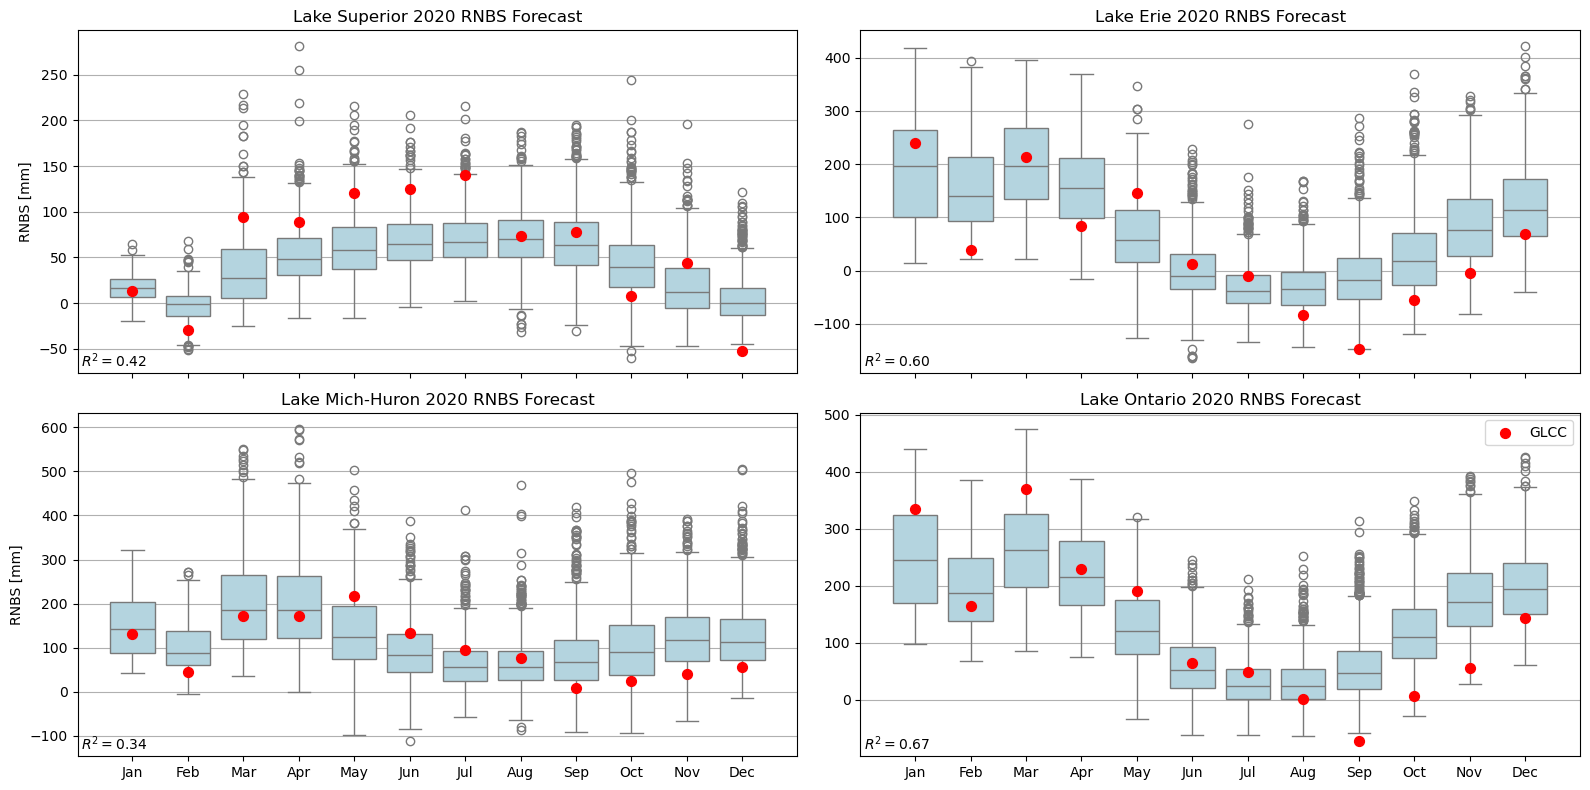

In [145]:
import seaborn as sns
from sklearn.metrics import r2_score

months = np.arange(0, 12)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# First boxplot
sns.boxplot(x='month', y='sup', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 0])
axes[0, 0].set_title('Lake Superior 2020 RNBS Forecast')
# Scatter plot for observations
axes[0, 0].scatter(obs['Month']-1, obs['sup'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 0].set_ylabel('RNBS [mm]')
axes[0, 0].set_xlabel('')
axes[0, 0].set_xticklabels('')
axes[0, 0].grid(axis='y')

r2_1 = r2_score(obs['sup'],df_y_mm_filtered.groupby('month')['sup'].median())
axes[0, 0].text(0.005, 0.009, f'$R^2 = {r2_1:.2f}$', ha='left', va='bottom', transform=axes[0, 0].transAxes)

# Second boxplot
sns.boxplot(x='month', y='eri', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Lake Erie 2020 RNBS Forecast')
# Scatter plot for observations
axes[0, 1].scatter(obs['Month']-1, obs['eri'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticklabels('')
axes[0, 1].grid(axis='y')

r2_2 = r2_score(obs['eri'],df_y_mm_filtered.groupby('month')['eri'].median())
axes[0, 1].text(0.005, 0.009, f'$R^2 = {r2_2:.2f}$', ha='left', va='bottom', transform=axes[0, 1].transAxes)

# Third boxplot
sns.boxplot(x='month', y='mih', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 0])
axes[1, 0].set_title('Lake Mich-Huron 2020 RNBS Forecast')
# Scatter plot for observations
axes[1, 0].scatter(obs['Month']-1, obs['mic_hur'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 0].set_ylabel('RNBS [mm]')
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].grid(axis='y')

r2_3 = r2_score(obs['mic_hur'],df_y_mm_filtered.groupby('month')['mih'].median())
axes[1, 0].text(0.005, 0.009, f'$R^2 = {r2_3:.2f}$', ha='left', va='bottom', transform=axes[1, 0].transAxes)

# Fourth boxplot
sns.boxplot(x='month', y='ont', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 1])
axes[1, 1].set_title('Lake Ontario 2020 RNBS Forecast')
# Scatter plot for observations
axes[1, 1].scatter(obs['Month']-1, obs['ont'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 1].grid(axis='y')
axes[1, 1].legend()

r2_4 = r2_score(obs['ont'],df_y_mm_filtered.groupby('month')['ont'].median())
axes[1, 1].text(0.005, 0.009, f'$R^2 = {r2_4:.2f}$', ha='left', va='bottom', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

In [146]:
# Calculate important statistics
stats = df_y_mm_filtered.groupby('month')['mih'].describe()
print("Important values:\n", stats)

Important values:
         count        mean         std         min         25%         50%  \
month                                                                       
1       120.0  150.892818   74.806551   43.157687   88.095191  141.166435   
2       232.0  103.862352   58.850311   -4.620384   59.616623   88.471156   
3       352.0  202.929451  109.211338   34.910765  119.814804  185.507980   
4       464.0  201.095646  104.403883   -0.370460  121.929730  185.487350   
5       580.0  137.487467   91.168967  -99.150120   73.737368  124.514815   
6       696.0   92.130445   71.809566 -111.485868   44.594966   82.088775   
7       812.0   65.029029   57.910865  -57.778027   24.433940   55.116546   
8       932.0   63.848497   61.233282  -86.322939   26.482971   56.219526   
9      1048.0   79.781973   80.373038  -92.818061   26.131625   68.288917   
10     1168.0  100.096885   89.092258  -93.026309   37.891368   90.644387   
11     1160.0  124.410980   77.785723  -66.862890   68.68